In [69]:
from optimize import optimize
from signals import compute_features, detect_trade_signals
from backtester import Backtester

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

### Load Data

In [113]:
## commodity prices ##
commodities = pd.read_csv('../Data/raw/commodity_prices.csv',index_col=['Date'])
commodities.index = pd.to_datetime(commodities.index)

## stock prices ##
stocks = pd.read_csv('../Data/raw/stock_prices.csv',index_col=['Date'])
stocks.index = pd.to_datetime(stocks.index)


prices = commodities.merge(stocks, left_index=True, right_index=True)

### Test optimizer

In [123]:
# Example pair
commodity = prices['GC=F Close']
stock = prices['STX']

param_grid = {
    'threshold': np.linspace(0,1,30),
    'streak': [2, 3, 4],
    'quantile': np.linspace(0,1,30),
    'lag': [1,2]
}

results = optimize(commodity, stock, param_grid)
print(results.head(10))

     threshold  streak  quantile  final_return  lag
182   0.034483       2  0.034483      1.824304    1
184   0.034483       2  0.068966      1.756859    1
242   0.034483       3  0.034483      1.713620    1
244   0.034483       3  0.068966      1.675732    1
180   0.034483       2  0.000000      1.672880    1
302   0.034483       4  0.034483      1.624312    1
304   0.034483       4  0.068966      1.596036    1
2     0.000000       2  0.034483      1.584346    1
186   0.034483       2  0.103448      1.579870    1
6     0.000000       2  0.103448      1.576093    1


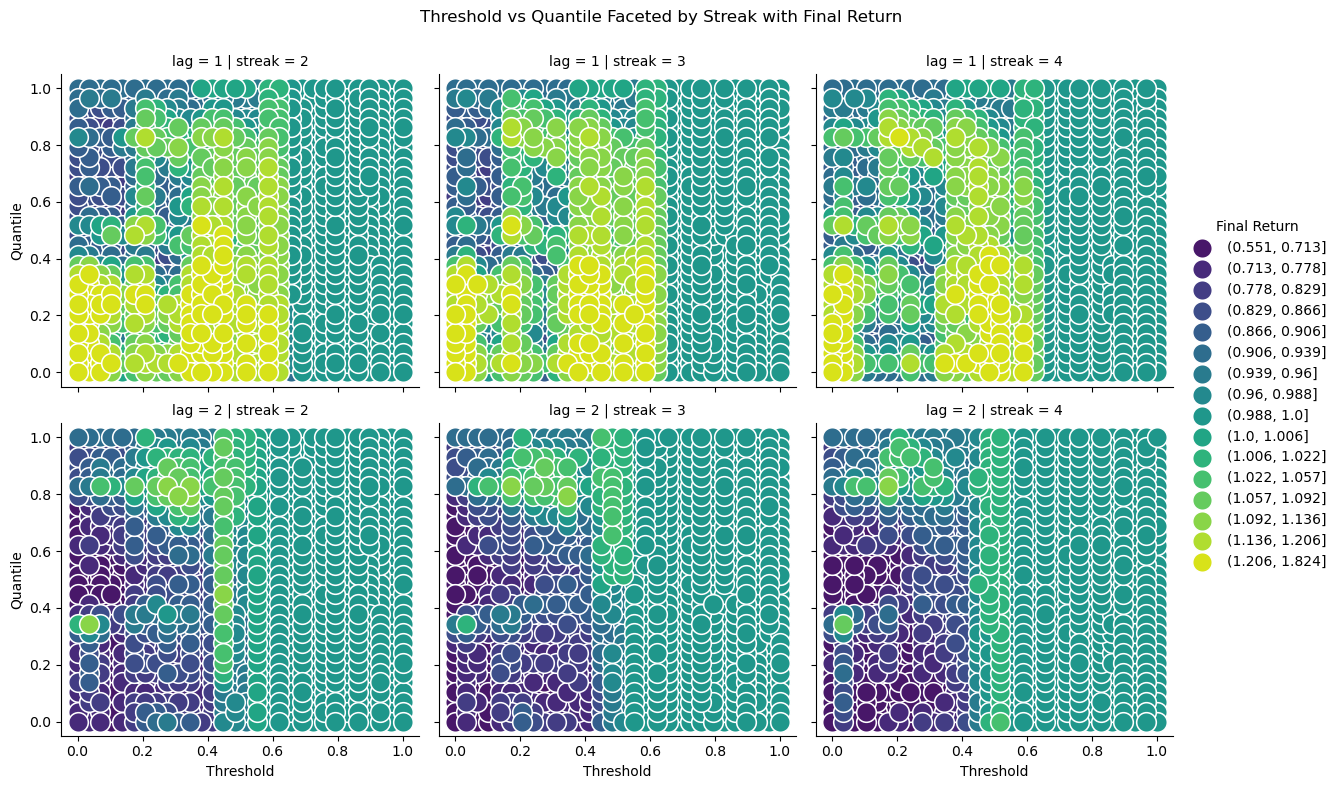

In [124]:
vmin = results['final_return'].min()
vmax = results['final_return'].max()
results['return_bin'] = pd.qcut(results['final_return'], q=25, duplicates='drop')

g = sns.FacetGrid(
    results, 
    col='streak',
    row='lag', 
    height=4, 
    sharex=True, 
    sharey=True,
    hue='return_bin',
    palette='viridis'   
)

g.map_dataframe(
    sns.scatterplot,
    x='threshold',
    y='quantile',
    size=None,
    s=200 
)


g.add_legend(title='Final Return')
g.set_axis_labels('Threshold', 'Quantile')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Threshold vs Quantile Faceted by Streak with Final Return')

plt.show()

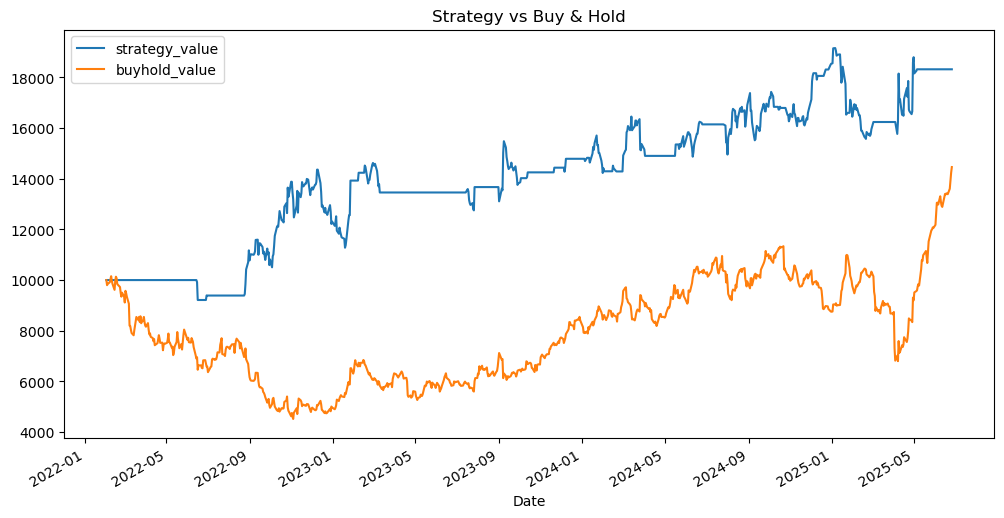

In [125]:
i = 0

threshold = results.iloc[i,:]['threshold']
min_streak = results.iloc[i,:]['streak']
quantile = results.iloc[i,:]['quantile']
lag = results.iloc[i,:]['lag']


features_df = compute_features(commodity,stock,lag)
features_df['stock_price'] = stock
signals_df = detect_trade_signals(
    features_df, 
    threshold=threshold, 
    min_streak=min_streak, 
    quantile=quantile)

bt = Backtester(
    prices = features_df,
    signals = signals_df,
    stock_col = 'stock_price',
    starting_capital = 10_000
)

result = bt.run()

# Visualize
result[['strategy_value', 'buyhold_value']].plot(
    figsize=(12,6), title='Strategy vs Buy & Hold'
)

plt.show()


#### Split data into train and test 

In [126]:
commodity = 'GC=F Close'
stock = 'SNAP'

split = len(prices)//2

train_commodity = prices.iloc[:split,:][commodity]
train_stock = prices.iloc[:split,:][stock]

test_commodity = prices.iloc[split:,:][commodity]
test_stock = prices.iloc[split:,:][stock]

param_grid = {
    'threshold': np.linspace(0,0.99,20),
    'streak': [2, 3, 4],
    'quantile': np.linspace(0,0.99,20),
    'lag': [1,2]
}

results = optimize(train_commodity, train_stock, param_grid)
print(results.head(10))

     threshold  streak  quantile  final_return  lag
485   0.208421       2  0.104211      2.084961    2
525   0.208421       3  0.104211      2.044566    2
483   0.208421       2  0.052105      2.036897    2
565   0.208421       4  0.104211      1.991656    2
405   0.156316       3  0.104211      1.981518    2
325   0.104211       4  0.104211      1.965312    2
523   0.208421       3  0.052105      1.953682    2
481   0.208421       2  0.000000      1.940939    2
323   0.104211       4  0.052105      1.920006    2
521   0.208421       3  0.000000      1.909690    2


#### view method on unseen data

* completely fails

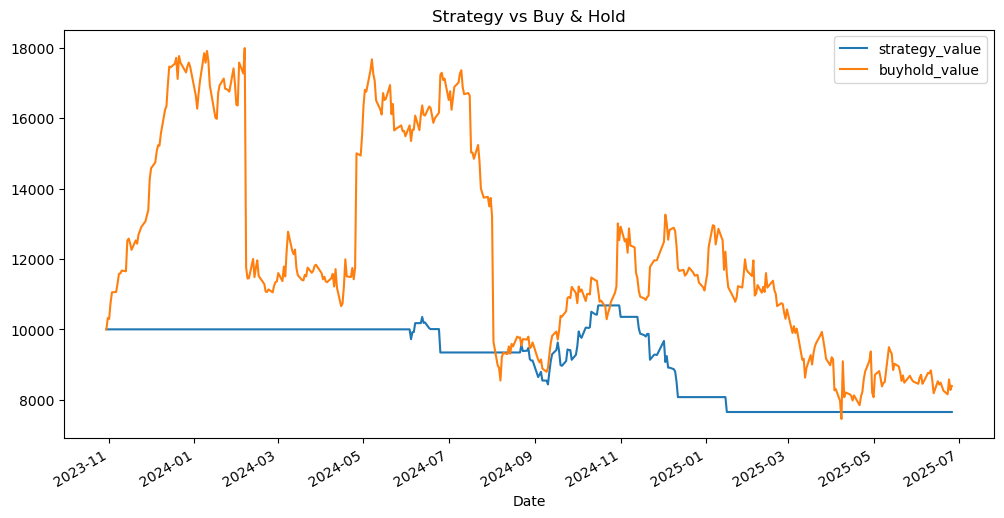

In [118]:
best_params = results.iloc[0] 

# Use best params on test data
features = compute_features(test_commodity, test_stock, lag=best_params['lag'])
signals = detect_trade_signals(
    features,
    threshold=best_params['threshold'],
    min_streak=int(best_params['streak']),
    quantile=best_params['quantile'],
)

bt = Backtester(
    prices = features.assign(stock_price = test_stock),
    signals = signals,
    stock_col = 'stock_price',
    starting_capital = 10_000
)

result = bt.run()

# Visualize
result[['strategy_value', 'buyhold_value']].plot(
    figsize=(12,6), title='Strategy vs Buy & Hold'
)

plt.show()


#### let's see how it would have performed if I trained on test data

In [127]:
param_grid = {
    'threshold': np.linspace(0,0.99,20),
    'streak': [2, 3, 4],
    'quantile': np.linspace(0,0.99,20),
    'lag': [1,2]
}

results = optimize(test_commodity, test_stock, param_grid)
print(results.head(10))

     threshold  streak  quantile  final_return  lag
682   0.260526       4  0.052105      1.369248    1
680   0.260526       4  0.000000      1.355163    1
684   0.260526       4  0.104211      1.326344    1
762   0.312632       3  0.052105      1.309544    1
686   0.260526       4  0.156316      1.299323    1
640   0.260526       3  0.000000      1.298073    1
760   0.312632       3  0.000000      1.296074    1
642   0.260526       3  0.052105      1.292205    1
802   0.312632       4  0.052105      1.289658    1
800   0.312632       4  0.000000      1.276392    1


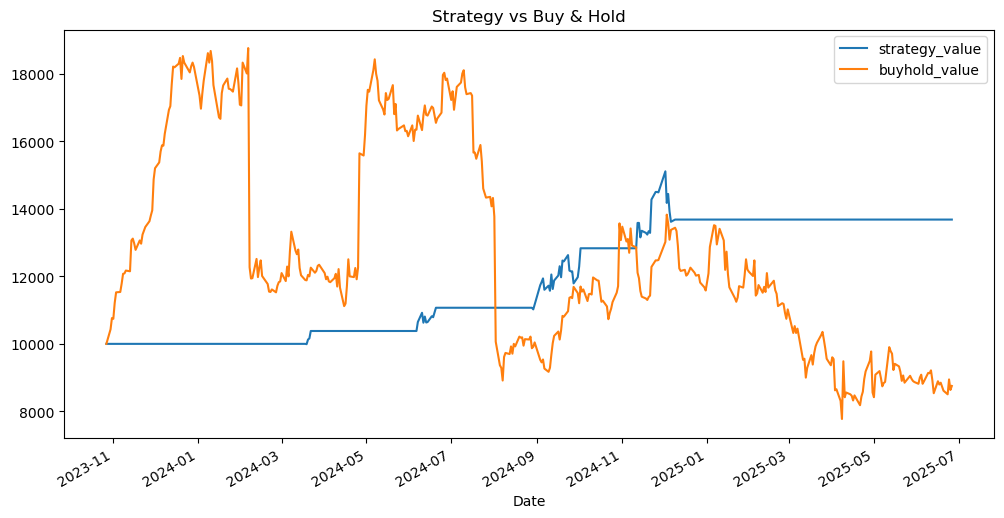

In [128]:
best_params = results.iloc[0] 

# Use best params on test data
features = compute_features(test_commodity, test_stock, lag=best_params['lag'])
signals = detect_trade_signals(
    features,
    threshold=best_params['threshold'],
    min_streak=int(best_params['streak']),
    quantile=best_params['quantile'],
)

bt = Backtester(
    prices = features.assign(stock_price = test_stock),
    signals = signals,
    stock_col = 'stock_price',
    starting_capital = 10_000
)

result = bt.run()

# Visualize
result[['strategy_value', 'buyhold_value']].plot(
    figsize=(12,6), title='Strategy vs Buy & Hold'
)

plt.show()


### Method is failing - Overfitting

* it's a bad look
* correlations change
* thresholds are too low
* might try changing the window size of the rolling correlations